In [1]:
import numpy as np
import matplotlib.pyplot as plt

from monte_carlo import ExactMCAgent, MCAgent
from envs.gridworld import GridworldEnv
from utils.grid_visualization import visualize_value_function, visualize_policy

np.random.seed(0)

## `GridWorld` 초기화하기

가로로 `nx` 개, 세로로 `ny` 개의 칸을 가진 `GridworldEnv`를 만듭니다!

In [2]:
nx, ny = 4, 4
env = GridworldEnv([ny, nx])

## Monte-carlo '에이전트' 초기화하기

드디어 우리는 '에이전트'라고 부를 수 있는 것을 다루게 되었습니다. `ExacatMCAgent` 는 __"도박의 도시 몬테카를로 (MC) 그리고 MC 정책추정"__ 에서 배운 vanilla 버전의 Monte-carlo 정책평가를 수행합니다. vanilla MC policy evaluation은 다음과 같은 수식으로 상태 가치함수를 추산합니다.

$$ V(s) \leftarrow \frac{G(s)}{N(s)}$$
$G(s)$ 는 상태 $s$의 리턴 추산치의 합. $N(s)$ 는 상태 $s$의 방문 횟수.

또한, 우리가 평가하려는 정책은 행동 가치함수 $Q(s,a)$ 에 대한 '$\epsilon$-탐욕적 정책' 이라고 생각해보겠습니다. 이제 한번 파이썬 구현체를 살펴보도록 할까요?

```python
class ExactMCAgent:
    """
    The exact Monte-Carlo agent.
    This agents performs value update as follows:
    V(s) <- s(s) / n(s)
    Q(s,a) <- s(s,a) / n(s,a)
    """

    def __init__(self,
                 gamma: float,
                 num_states: int,
                 num_actions: int,
                 epsilon: float):
        self.gamma = gamma
        self.num_states = num_states
        self.num_actions = num_actions
        self.epsilon = epsilon

        self._eps = 1e-10  # for stable computation of V and Q. NOT the one for e-greedy !
```

일단 클래스의 컨스트럭터의 인자부터 살펴볼까요? 
1. `gamma` : 감가율
2. `num_states` : 상태공간의 크기 (서로 다른 상태의 갯수)
3. `num_actions` : 행동공간의 크기 (서로 다른 행동의 갯수)
4. `epsilon`: $\epsilon$-탐욕적 정책의 파라미터

In [3]:
mc_agent = ExactMCAgent(gamma=1.0,
                        num_states=nx * ny,
                        num_actions=4,
                        epsilon=1.0) # epsilon=1.0? -> 모든 행동을 같은 확률로 하는 정책

In [4]:
# 좀 더 직관적인 가시화를 위해서 action 인덱스를 방향으로 바꿔줍니다.
action_mapper = {
    0: 'UP',
    1: 'RIGHT',
    2: 'DOWN',
    3: 'LEFT'
}

## My first '에이전트-환경' interaction

강화학습을 구현할 때 전형적인 형태의 `'에이전트-환경' interaction` 은 다음과 같습니다.

```
반복:
    에피소드 시작
    반복:
        현재 상태 <- 환경으로 부터 현재 상태 관측
        현재 행동 <- 에이전트의 정책함수(현재 상태)
        다음 상태, 보상 <- 환경에 '현재 행동'을 가함
        if 다음 상태 == 종결 상태
            반복문 탈출
    에이전트의 가치함수 평가 및 정책함수 개선
```

파이썬을 활용한 구현체를 확인해볼까요?

1. 에피소드 (재) 시작하기 
우리가 사용할 `GridworldEnv`에서는, `env.reset()`을 활용해서 주어진 환경을 재시작합니다.


2. 환경에서 현재 상태 관측하기
우리가 사용할 `GridworldEnv`에서는, `env.observe()` 를 활용해서 현재 상태를 관측합니다.


3. 현재 상태로 부터 정책함수로 행동 결정하기
`action = mc_agent.get_action(cur_state)` 을 활용해서 정책함수로 현재 상황에 대한 행동을 구할 수 있습니다.

```python
def get_action(self, state):
    prob = np.random.uniform(0.0, 1.0, 1)
    # e-greedy policy over Q
    if prob <= self.epsilon:  # random
        action = np.random.choice(range(self.num_actions))
    else:  # greedy
        action = self._policy_q[state, :].argmax()
    return action
```

4. 현재 행동을 환경에 가하기
`next_state, reward, done, info = env.step(action)` 을 활용해서 현재 상태에서 주어진 행동을 가한 후(!) 의 상태 `next_state` , 그에 따른 보상 `reward`, 다음 상태가 종결상태인지 여부 `done` 및 환경에 대한 정보 `info`를 확인 할 수 있습니다.

### Note

여러분들이 사용할 모든 환경이 `env.reset()`, `'env.step()'` 과 같이 표준화된 형태로 환경을 재시작하지는 않을 수도 있습니다. 
하지만 `gym` 환경을 상속받아 만들어진 환경들은 앞서 설명드린 표준화된 인터페이스를 갖추는 것을 권장하고 있습니다. 차후에 `gym` 의 환경을 상속 받은 환경을 사용하시게 된다면 표준화된 인터페이스가 구현되어있는 지 확인해보시는 것도 좋을것같네요. 또 여러분들께서 직접 환경을 구축하게 된다면, 해당 인터페이스를 구현하시는게 좋겠죠?


In [5]:
env.reset()
step_counter = 0
while True:
    print("At t = {}".format(step_counter))
    env._render()
    
    cur_state = env.observe()
    action = mc_agent.get_action(cur_state)
    next_state, reward, done, info = env.step(action)
    
    print("state : {}".format(cur_state))
    print("aciton : {}".format(action_mapper[action]))
    print("reward : {}".format(reward))
    print("next state : {} \n".format(next_state))
    step_counter += 1
    if done:
        break

At t = 0
T  o  o  o
o  o  o  o
o  o  o  o
o  x  o  T
state : 13
aciton : RIGHT
reward : -1.0
next state : 14 

At t = 1
T  o  o  o
o  o  o  o
o  o  o  o
o  o  x  T
state : 14
aciton : LEFT
reward : -1.0
next state : 13 

At t = 2
T  o  o  o
o  o  o  o
o  o  o  o
o  x  o  T
state : 13
aciton : RIGHT
reward : -1.0
next state : 14 

At t = 3
T  o  o  o
o  o  o  o
o  o  o  o
o  o  x  T
state : 14
aciton : DOWN
reward : -1.0
next state : 14 

At t = 4
T  o  o  o
o  o  o  o
o  o  o  o
o  o  x  T
state : 14
aciton : DOWN
reward : -1.0
next state : 14 

At t = 5
T  o  o  o
o  o  o  o
o  o  o  o
o  o  x  T
state : 14
aciton : UP
reward : -1.0
next state : 10 

At t = 6
T  o  o  o
o  o  o  o
o  o  x  o
o  o  o  T
state : 10
aciton : DOWN
reward : -1.0
next state : 14 

At t = 7
T  o  o  o
o  o  o  o
o  o  o  o
o  o  x  T
state : 14
aciton : DOWN
reward : -1.0
next state : 14 

At t = 8
T  o  o  o
o  o  o  o
o  o  o  o
o  o  x  T
state : 14
aciton : RIGHT
reward : -1.0
next state : 15 



## Monte-calro 정책 평가

이제 Vanilla version의 Monte-carlo Policy evaluation을 수행해보도록 할까요?

In [6]:
def run_episode(env, agent):
    env.reset()
    states = []
    actions = []
    rewards = []
    
    while True:
        state = env.observe()
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        
        if done:
            break
    
    episode = (states, actions, rewards)
    agent.update(episode)

### `agent.update(episode)` ?

우리 실습에서는 every-visit Monte-carlo 정책 평가를 활용해서 정책에 해당하는 가치함수를 추산할 것입니다. 

Monte-carlo 정책평가는 하나의 온전한 에피스드가 필요했던거 다들 기억하시죠? 따라서 하나의 에피소드가 끝난 후에 `agent.update(episode)`를 수행하게 됩니다. 그러면 `agent.update(episode)` 에서는 무슨일이 일어날까요?

```python
def update(self, episode):
    states, actions, rewards = episode

    # reversing the inputs!
    # for efficient computation of returns
    states = reversed(states)
    actions = reversed(actions)
    rewards = reversed(rewards)

    iter = zip(states, actions, rewards)
    cum_r = 0
    for s, a, r in iter:
        cum_r *= self.gamma
        cum_r += r

        self.n_v[s] += 1
        self.n_q[s, a] += 1

        self.s_v[s] += cum_r
        self.s_q[s, a] += cum_r
```

In [7]:
%%time
mc_agent.reset_statistics() # agent.n_v, agent.n_q, agent.s_v, agent.s_q 을 0으로 초기화 합니다.
for _ in range(10):  
    run_episode(env, mc_agent)

CPU times: user 6.42 ms, sys: 869 µs, total: 7.28 ms
Wall time: 6.57 ms


## agent.compute_values()

앞서 추산한 리턴의 추산치와 각 상태 $s$ 및 상태-행동 $(s,a)$ 방문 횟수를 활용해서 상태 가치함수 $V$ 와 행동 가치함수 $Q$ 를 계산합니다.

```python
def compute_values(self):
    self.v = self.s_v / (self.n_v + self._eps)
    self.q = self.s_q / (self.n_q + self._eps)
```

In [8]:
mc_agent.compute_values()

In [9]:
mc_agent.v

array([  0.        ,  -2.8       , -12.5       , -15.56521739,
       -13.625     , -16.88888889, -19.5       , -14.33333333,
       -16.83333333, -27.7       , -32.57142857, -18.77777778,
       -36.53846154, -33.5       , -30.8       ,   0.        ])

## Monte-carlo 방식으로 추산한 $V(s)$ 이 정말 맞을까요?

우리는 이 `GridworldEnv` 에 대해서 정답을 알고 있죠? 바로 `동적 계획법`을 통해서 계산한 $V(s)$ 입니다. 여기서는 `Monte-carlo` 로 추산한 가치함수와 동적 계획법으로 계산한 가치함수의 값을 비교해볼까요?

In [10]:
from tensorized_dp import TensorDP

dp_agent = TensorDP()
dp_agent.set_env(env)

Tensor DP agent initialized
Environment spec:  Num. state = 16 | Num. actions = 4 


In [11]:
%%time
v_pi = dp_agent.policy_evaluation()

CPU times: user 3.32 ms, sys: 868 µs, total: 4.19 ms
Wall time: 3.51 ms


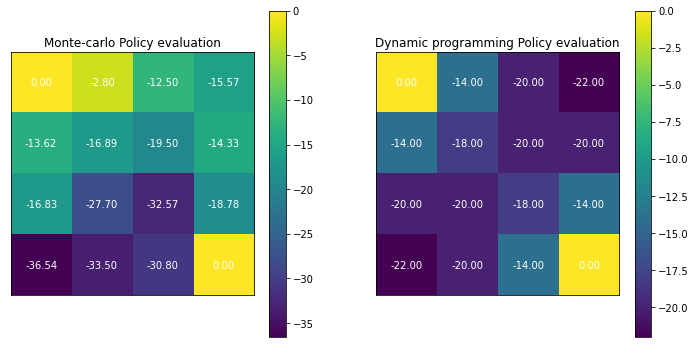

In [12]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], mc_agent.v, nx, ny)
_ = ax[0].set_title("Monte-carlo Policy evaluation")

visualize_value_function(ax[1], v_pi, nx, ny)
_ = ax[1].set_title("Dynamic programming Policy evaluation")

## Monte-carlo 기법에 실망하셨나요? 

`dp_agent` 와 `mc_agent`에게 비슷한 시간을 주고 가치 함수를 평가해봤었는데
`mc_agent` 의 결과가 영 시원치 않죠? 바로 `MDP` 환경모델을 활용 여부에 따른 차이입니다.

`dp_agent`는 환경에 대해 훤히 알고 있으니, 짧은 시간 (혹은 계산) 만에 원하는 답을 알아내는 것은
어쩌면 당연하겠죠. `mc_agent`에게 조금 더 시간을 줘 보는게 어떨까요?

In [13]:
total_eps = 2000
log_every = 500

def run_episodes(env, agent, total_eps, log_every):
    mc_values = []
    log_iters = []

    agent.reset_statistics()
    for i in range(total_eps+1):  
        run_episode(env, agent)

        if i % log_every == 0:
            agent.compute_values()
            mc_values.append(agent.v.copy())
            log_iters.append(i)
    
    info = dict()
    info['values'] = mc_values
    info['iters'] = log_iters
    return info

In [14]:
info = run_episodes(env, mc_agent, total_eps, log_every)

In [15]:
log_iters = info['iters']
mc_values = info['values']

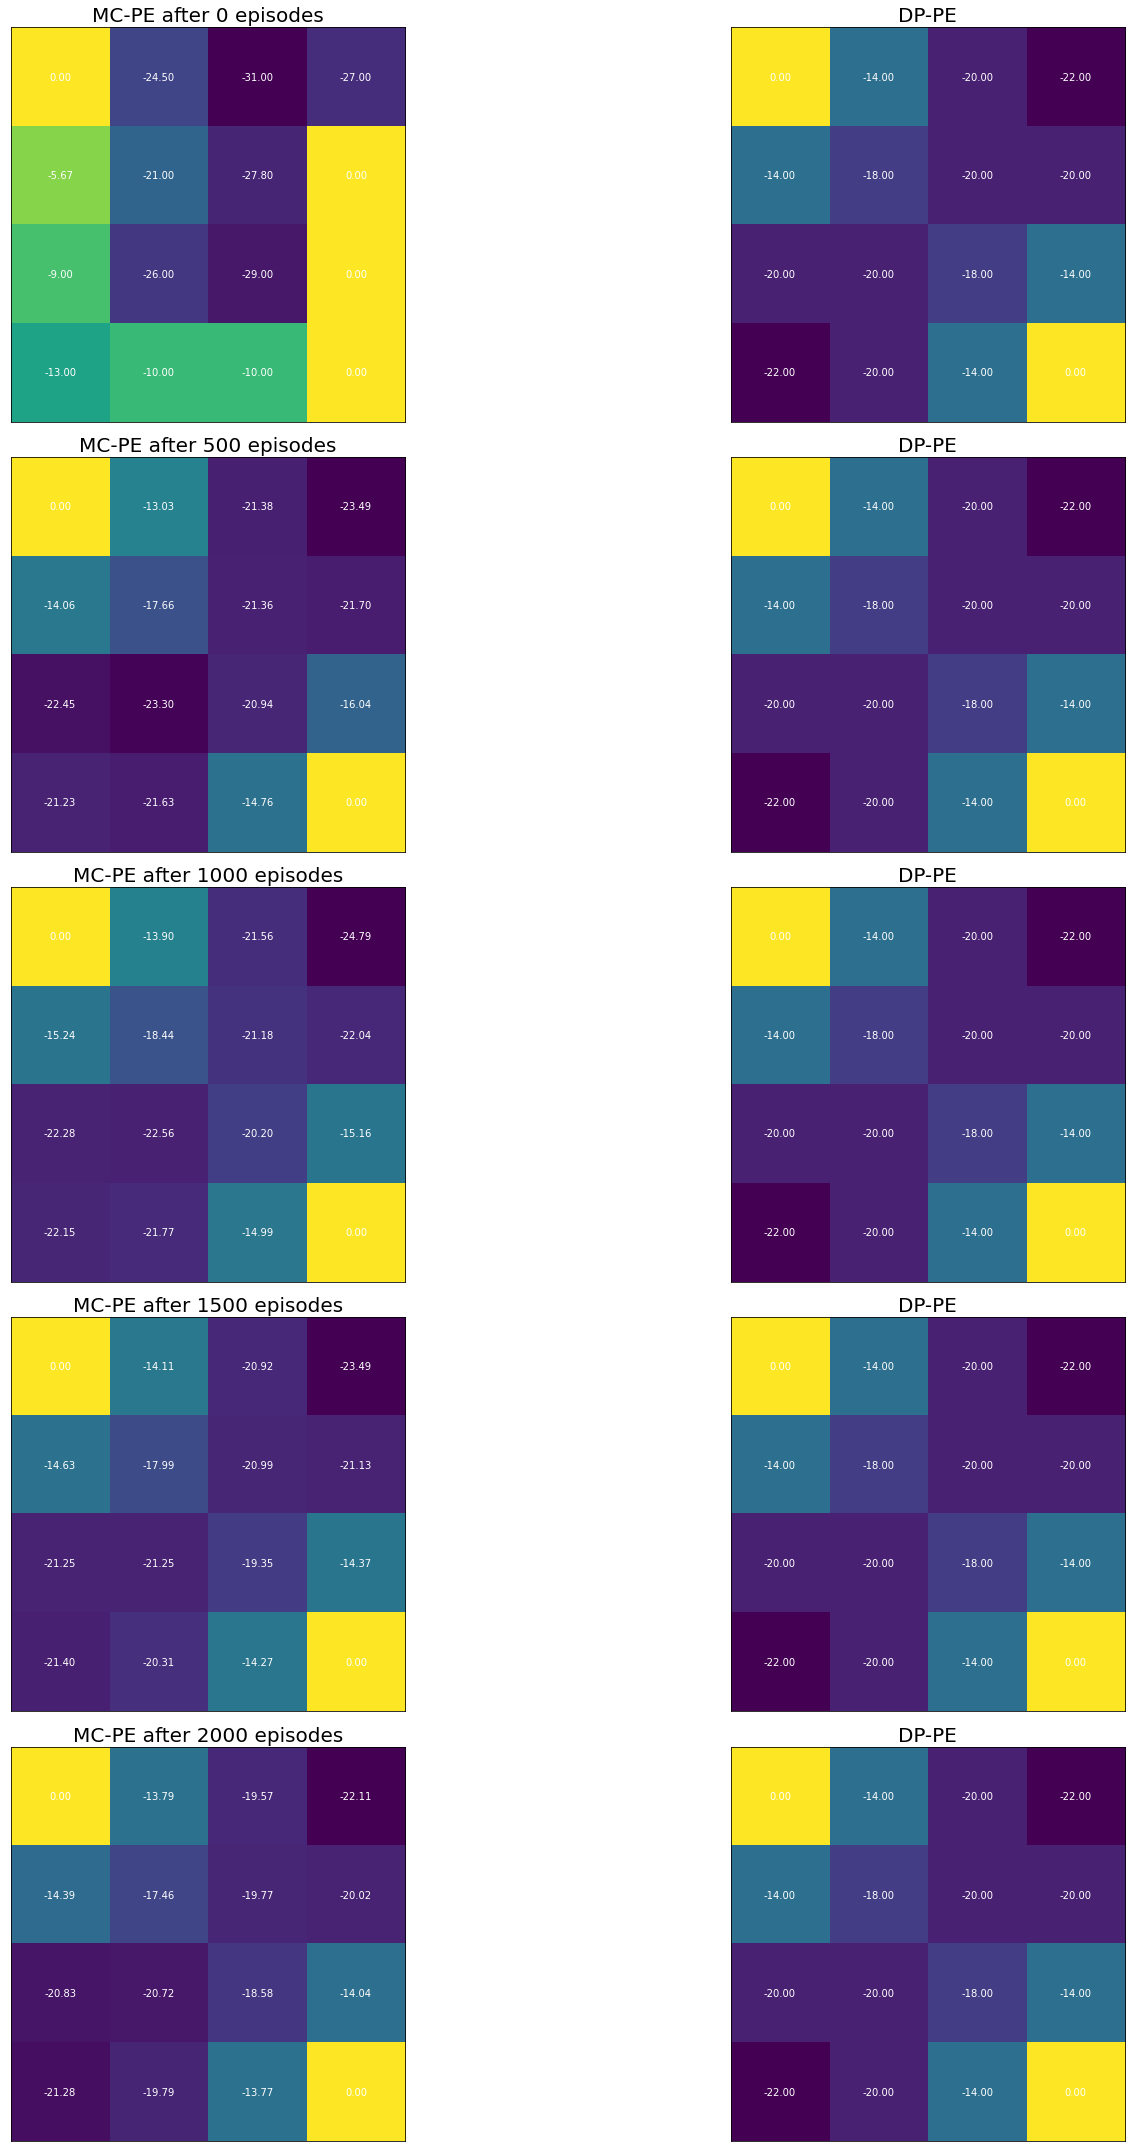

In [16]:
n_rows = len(log_iters)
figsize_multiplier = 10


fig, ax = plt.subplots(n_rows, 2, figsize=(n_rows*figsize_multiplier*0.5, 
                                           3*figsize_multiplier))

for viz_i, i in enumerate(log_iters):
    visualize_value_function(ax[viz_i, 0], mc_values[viz_i], nx, ny,
                            plot_cbar=False)
    _ = ax[viz_i, 0].set_title("MC-PE after {} episodes".format(i), size=20)

    visualize_value_function(ax[viz_i, 1], v_pi, nx, ny,
                             plot_cbar=False)
    _ = ax[viz_i, 1].set_title("DP-PE", size=20)

fig.tight_layout()

## 혹시 눈치 채셨나요? 매 실행마다 결과값이 달라진다는 것을?

Monte-carlo Policy evaluation 에서는 매 실행마다, 가치함수 추산값이 달라지는것을 확인하셨나요?
그러면 한번 매 실행마다 얼마나 결과값이 다른지, 즉, 가치함수 `추산치의 분산`이 얼마나 되는지 확인해볼까요?

In [17]:
reps = 10
values_over_runs = []
total_eps = 3000
log_every = 30

for i in range(reps):
    print("start to run {} th experiment ... ".format(i))
    info = run_episodes(env, mc_agent, total_eps, log_every)
    values_over_runs.append(info['values'])
    
values_over_runs = np.stack(values_over_runs)

start to run 0 th experiment ... 
start to run 1 th experiment ... 
start to run 2 th experiment ... 
start to run 3 th experiment ... 
start to run 4 th experiment ... 
start to run 5 th experiment ... 
start to run 6 th experiment ... 
start to run 7 th experiment ... 
start to run 8 th experiment ... 
start to run 9 th experiment ... 


In [18]:
v_pi_expanded = np.expand_dims(v_pi, axis=(0,1))

In [19]:
errors = np.linalg.norm(values_over_runs - v_pi_expanded, axis=-1)
error_mean = np.mean(errors, axis=0)
error_std = np.std(errors, axis=0)

np.save('mc_errors.npy', errors)

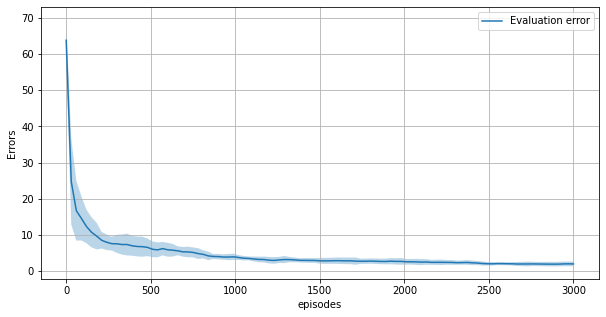

In [20]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.grid()
ax.fill_between(x=info['iters'],
                y1=error_mean + error_std,
                y2=error_mean - error_std,
                alpha=0.3)
ax.plot(info['iters'], error_mean, label='Evaluation error')
ax.legend()
_ = ax.set_xlabel('episodes')
_ = ax.set_ylabel('Errors')

## Incremental Monte-carlo 정책 평가

앞선 예제들에서는 Vanilla version의 MC 정책 평가에 대해서 살펴보았습니다. 이 방식은 가치함수 추산에 리턴들의 합과 각 상상태 $s$ 및 상태-행동 $(s,a)$ 방문 횟수를 따로 기록하여 두 통계치를 활용해서 가치함수들을 추산하였습니다. 이번에는 `적당히 작은` 학습률 $\alpha$ (learning rate; lr)을 활용하는 방식을 이용해서 정책 평가를 수행해보도록 할까요?

$$V(s) \leftarrow V(s) + \alpha (G_t - V(s))$$

`MCAgent` 는 기존의 `ExacatMCAgent`와 유사하나 추가적으로 학습률 $\alpha$  인자를 하나 더 받습니다.

In [21]:
mc_agent = MCAgent(gamma=1.0,
                   lr=1e-3,
                   num_states=nx * ny,
                   num_actions=4,
                   epsilon=1.0)

## `MCAgent.update()`

새로운 `MCAgent`의 학습방식이 학습률 $\alpha$을 활용하니, 그에 따라 `update()` 함수도 조금 수정이 필요하겠죠? 수정된 `update()`함수를 살펴볼까요?

```python
def update(self, episode):
    states, actions, rewards = episode

    # reversing the inputs!
    # for efficient computation of returns
    states = reversed(states)
    actions = reversed(actions)
    rewards = reversed(rewards)

    iter = zip(states, actions, rewards)
    cum_r = 0
    for s, a, r in iter:
        cum_r *= self.gamma
        cum_r += r

        self.v[s] += self.lr * (cum_r - self.v[s])
        self.q[s, a] += self.lr * (cum_r - self.q[s, a])
```

In [22]:
for _ in range(5000):
    run_episode(env, mc_agent)

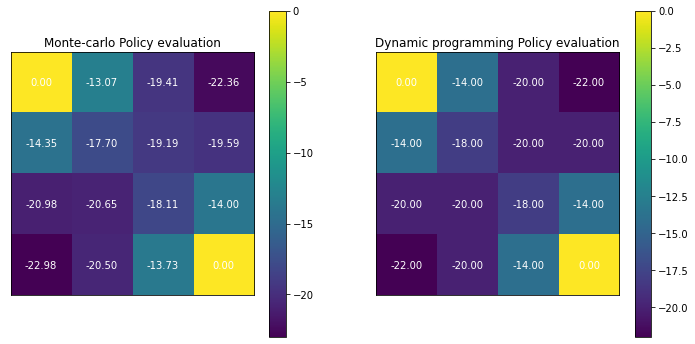

In [23]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], mc_agent.v, nx, ny)
_ = ax[0].set_title("Monte-carlo Policy evaluation")

visualize_value_function(ax[1], v_pi, nx, ny)
_ = ax[1].set_title("Dynamic programming Policy evaluation")

## MCAgent, 다른 학습률 $\alpha$에 대해선 어떨까?

MCAgent의 학습률 $\alpha$ 는 분명히 상태 (행동) 가치함수 추산에 영향을 미칠텐데, 어떻게 영향을 미치는지 알아보도록 할까요?

In [24]:
def run_mc_agent_with_lr(agent, env, lr):
    agent.reset()
    agent.lr = lr
    
    for _ in range(5000):
        run_episode(env, agent)
    
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    visualize_value_function(ax[0], mc_agent.v, nx, ny)
    _ = ax[0].set_title("Monte-carlo Policy evaluation")

    visualize_value_function(ax[1], v_pi, nx, ny)
    _ = ax[1].set_title("Dynamic programming Policy evaluation")

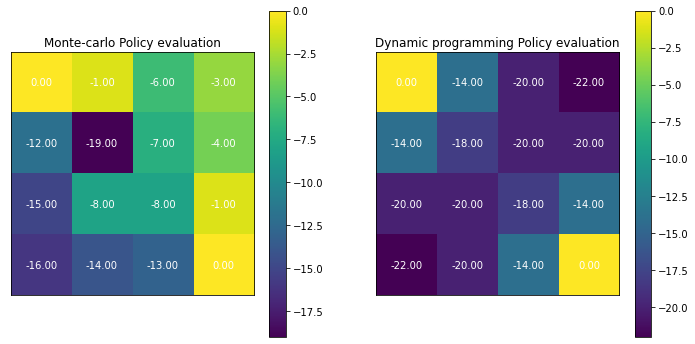

In [25]:
run_mc_agent_with_lr(agent=mc_agent,
                     env=env,
                     lr=1.0)

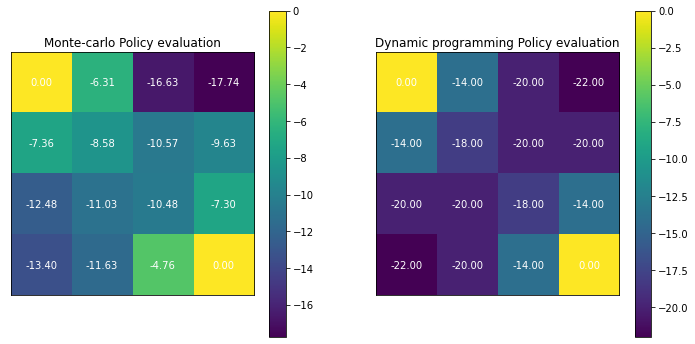

In [26]:
run_mc_agent_with_lr(agent=mc_agent,
                     env=env,
                     lr=1e-1)

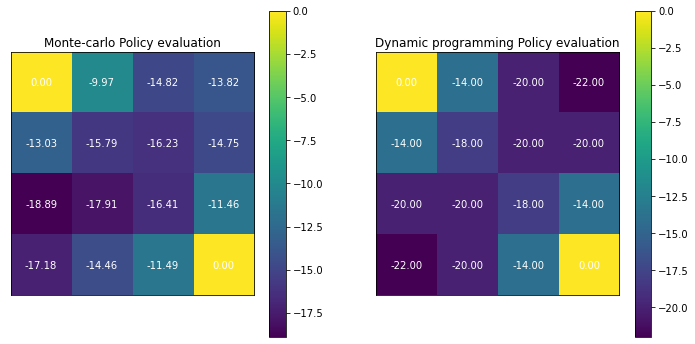

In [27]:
run_mc_agent_with_lr(agent=mc_agent,
                     env=env,
                     lr=1e-2)